In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import timedelta

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from catboost import CatBoostClassifier

import pickle

Прочитаем данные

In [69]:
df_all = pd.read_excel('157_2_All_incidents_Jan-May_.xlsx')

In [70]:
df_repeated = pd.read_excel('157_1_OnlyRepeatingIncidents_Jan-May.xlsx')

In [72]:
df_all.head()

,OBJECTID,CREATE_DATE,CLOSETIME,idN,DECLARED_FAULT,DIAGNOSIS,SOLUTION,CLOSEREI,DEPARTMENTEICLOSER,MI,RESPZONE_PROBLEM,EI1_WAS_ON_DUS,WFM_EI1,COUNT_WFM_EI1,CLOSINGSTATUS,CHANNELTYPE,CLIENTCHANNELADDRESS
0,E0770441226,2012-03-24 23:39:00,2014-05-10 09:22:00,miloapedbvapwlom,13_23,13_24,1_y_2,1,1,NaN,2,0,1,2.0,Выполнен,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.Чкалова, д...."
1,E0770708604,2012-05-05 11:25:00,2014-03-12 21:55:00,loyqRyedbvqRbvy,13_24,Прочее,111_19,2,2,A0412056811,2,0,0,NaN,NaN,2,"РФ, обл., рай., рег.Ленинградская, г.1, ул.ули..."
2,E0771112679,2012-07-10 18:25:00,2014-01-31 11:24:00,milobvedmapylobv,13_23,13_24,1_y_2,3,2,NaN,2,0,1,1.0,Выполнен,1,NaN
3,E0771117154,2012-07-11 14:26:00,2014-01-16 16:43:00,miiqRmiloedapnr,13_23,13_24,1_y_2,4,2,NaN,2,0,1,2.0,Выполнен,1,NaN
4,E0771291227,2012-08-08 15:22:00,2014-02-21 00:57:00,miloapedloybvyed,13_23,13_24,1_y_2,1,1,NaN,2,0,1,2.0,Выполнен,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.проезд 3-й ..."


In [73]:
df_repeated.head()

,OBJECTID,CREATE_DATE,CLOSETIME,LIFETIME_EI1_DAYS,LIFETIME_EI1_HRS,IdN,DECLARED_FAULT,DIAGNOSIS,SOLUTION,CLOSEREI,...,SERVICE,SERVICE_NEXT,CLIENTCHANNELADDRESS,NEXT_CLIENTCHANNELADDRESS,SEGMENT,SOURCE,COUNT_EI1_WAS_ON_DUS,COUNT_EI2_WAS_ON_DUS,LASTWFM_EI1,LASTWFM_EI2
0,E0773702457,2013-07-07 22:53:00,2014-02-28 03:00:00,235.17,5644.11,milomwwedediqR,4_u_4,4_xx_4,Проведена калибровка _.,8,...,1.0,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Инесс...","РФ, обл., рай., рег.СПб, г.СПб, ул.улица Инесс...",2,1,NaN,NaN,NaN,NaN
1,E0773716880,2013-07-10 17:27:00,2014-02-28 03:00:00,232.39,5577.54,miloapyymqRlolo,4_u_4,4_xx_4,Проведена калибровка _.,8,...,1.0,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Черно...","РФ, обл., рай., рег.СПб, г.СПб, ул.улица Черно...",2,1,NaN,NaN,NaN,586834032.0
2,E0774115851,2013-09-01 17:42:00,2014-02-01 00:46:00,152.29,3655.08,miiwyqRnriyi,33_3,13_1,111_5,2,...,1.0,4,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Хачат...","РФ, обл., рай., рег.СПб, г.СПб, ул.улица Хачат...",2,1,NaN,NaN,42844112.0,NaN
3,E0774519528,2013-10-18 10:08:00,2014-02-28 03:00:00,132.70,3184.85,miiqRapedbvbvlom,4_u_16,4_2,Проведена калибровка _.,8,...,1.0,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.проспект Во...","РФ, обл., рай., рег.СПб, г.СПб, ул.проспект Во...",2,1,NaN,NaN,NaN,NaN
4,E0774535030,2013-10-19 20:42:00,2014-02-28 03:00:00,131.26,3150.29,miiqRbvnrinryw,4_u_4,4_2,Проведена калибровка _.,8,...,1.0,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.проезд Пого...","РФ, обл., рай., рег.СПб, г.СПб, ул.проезд Пого...",2,1,NaN,NaN,NaN,NaN


Выкинем повторки из датафрейма со всеми инфидентами.

In [77]:
rep_in_all = set(df_all['OBJECTID']) & set(df_repeated['OBJECTID'])

In [78]:
df_single = df_all[~df_all['OBJECTID'].isin(rep_in_all)]

Посмотрим на то что осталось.

In [82]:
rep_single_common_cols = set(df_single.columns) & set(df_repeated.columns)

In [83]:
for col in list(rep_single_common_cols - set(['CREATE_DATE', 'CLOSETIME', 'CLIENTCHANNELADDRESS'])):
    print(df_single[col].value_counts())
    print(df_repeated[col].value_counts())

16_21                                                     16565
7_4                                                       14014
16_20                                                     13490
4_u_8                                                     10794
4_u_24                                                     8318
13_6                                                       8304
13_2                                                       6619
33_3                                                       6321
13_7                                                       5544
4_u_4                                                      5295
4_u_18                                                     5103
4_u_21                                                     4394
7_1                                                        4077
16_5                                                       3980
4_u_14                                                     2891
Swap ONT Huawei                         

В файле со всеми инцидентами нет колонки с информацией о том сколько дней и часов прошло с момента начала до закрытия инцидента. Посчитаем дни и часы.

In [84]:
df_single['LIFETIME_EI1_DAYS'] = round((df_single['CLOSETIME'] - df_single['CREATE_DATE']) / timedelta(days=1), 2)

/home/vanya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [85]:
df_single['LIFETIME_EI1_HRS'] = round((df_single['CLOSETIME'] - df_single['CREATE_DATE']) / timedelta(hours=1), 2)

/home/vanya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Кодируем единичные случаи "1" и повторку "0"

In [86]:
df_single['target'] = 1

/home/vanya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [87]:
df_repeated['target'] = 0

Получим список колонок, которые повоторяются в файлах с повторкой и без

In [88]:
rep_single_common_cols = list(set(df_single.columns) & set(df_repeated.columns))

In [89]:
rep_single_common_cols

['WFM_EI1',
 'OBJECTID',
 'LIFETIME_EI1_HRS',
 'DECLARED_FAULT',
 'CHANNELTYPE',
 'DIAGNOSIS',
 'LIFETIME_EI1_DAYS',
 'COUNT_WFM_EI1',
 'SOLUTION',
 'MI',
 'CREATE_DATE',
 'CLOSETIME',
 'EI1_WAS_ON_DUS',
 'RESPZONE_PROBLEM',
 'CLOSINGSTATUS',
 'target',
 'CLOSEREI',
 'DEPARTMENTEICLOSER',
 'CLIENTCHANNELADDRESS']

Случаев повторки значительно меньше, чем случаев без повторки. Cделаем undersampling и oversampling. 
В конечной версии я использовал датасет с андерсемплингом, потому что результат был примерно один, а считалось быстрее.

In [90]:
len_rep = len(df_repeated)

In [91]:
len_single = len(df_single)

In [92]:
df_concatinated = pd.concat([df_single[rep_single_common_cols], 
                             df_repeated[rep_single_common_cols].sample(n=len_single, replace=True)])

In [93]:
df_concatinated = pd.concat([df_single[rep_single_common_cols].sample(n=len_rep, replace=True), 
                             df_repeated[rep_single_common_cols]])

In [94]:
df_concat_shuffeld = shuffle(df_concatinated)

In [95]:
df_concat_shuffeld.head()

,WFM_EI1,OBJECTID,LIFETIME_EI1_HRS,DECLARED_FAULT,CHANNELTYPE,DIAGNOSIS,LIFETIME_EI1_DAYS,COUNT_WFM_EI1,SOLUTION,MI,CREATE_DATE,CLOSETIME,EI1_WAS_ON_DUS,RESPZONE_PROBLEM,CLOSINGSTATUS,target,CLOSEREI,DEPARTMENTEICLOSER,CLIENTCHANNELADDRESS
16823,1,E0775949542,24.68,16_21,6,16_28,1.02,1.0,113_y_5,NaN,2014-04-04 16:01:00,2014-04-05 16:43:00,0,2,Выполнен,0,1,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.микрорайон ..."
160175,1,E0776194455,3.30,16_7,6,16_11,0.14,1.0,110_y_4,NaN,2014-05-04 12:43:00,2014-05-04 16:01:00,0,2,Выполнен,1,1,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Молос..."
6804,1,E0775208329,53.83,7_4,4,7_4,2.24,2.0,Повреждение на РК/ОРК,NaN,2014-01-08 13:50:00,2014-01-10 19:40:00,0,2,Выполнен,1,1,1,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Циолк..."
116239,0,E0775913130,0.10,4_u_14,4,4_xx_13,0.00,NaN,16_y_6,NaN,2014-03-31 11:43:00,2014-03-31 11:49:00,0,2,NaN,1,28,2,"РФ, обл., рай., рег.СПб, г.СПб, ул.улица Остря..."
9918,0,E0775622876,0.17,13_7,2,13_7,0.00,NaN,109_y_4,NaN,2014-02-24 23:39:00,2014-02-24 23:49:00,0,2,NaN,0,3,2,"РФ, обл., рай., рег.Ленинградская, г.13, ул.ул..."


In [96]:
df_concat_shuffeld.reset_index(drop=True, inplace=True)

Выберем категориальные колонки для кодировки One Hot Encoding.

In [97]:
ls_cat_features = ['CLOSINGSTATUS', 'RESPZONE_PROBLEM', 'COUNT_WFM_EI1', 'CHANNELTYPE', 'CLOSEREI', 
                  'DEPARTMENTEICLOSER', 'WFM_EI1', 'EI1_WAS_ON_DUS']

In [98]:
ls_features_used = ['CLOSINGSTATUS', 'RESPZONE_PROBLEM', 'COUNT_WFM_EI1', 'CHANNELTYPE', 'CLOSEREI', 
                  'DEPARTMENTEICLOSER', 'WFM_EI1', 'LIFETIME_EI1_HRS', 'LIFETIME_EI1_DAYS', 'EI1_WAS_ON_DUS']

In [99]:
df_encoded = pd.get_dummies(df_concat_shuffeld[ls_features_used], columns=ls_cat_features, drop_first=True, dummy_na=True)

In [100]:
df_encoded.head()

,LIFETIME_EI1_HRS,LIFETIME_EI1_DAYS,CLOSINGSTATUS_Не выполнен,CLOSINGSTATUS_Отменен,CLOSINGSTATUS_nan,RESPZONE_PROBLEM_2.0,RESPZONE_PROBLEM_4.0,RESPZONE_PROBLEM_5.0,RESPZONE_PROBLEM_7.0,RESPZONE_PROBLEM_8.0,...,DEPARTMENTEICLOSER_35.0,DEPARTMENTEICLOSER_36.0,DEPARTMENTEICLOSER_37.0,DEPARTMENTEICLOSER_40.0,DEPARTMENTEICLOSER_42.0,DEPARTMENTEICLOSER_nan,WFM_EI1_1.0,WFM_EI1_nan,EI1_WAS_ON_DUS_1.0,EI1_WAS_ON_DUS_nan
0,24.68,1.02,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3.30,0.14,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,53.83,2.24,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.10,0.00,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.17,0.00,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
y = df_concat_shuffeld['target']

Мы будем классифицировать данные используя XGBoost. Сделаем подбор лучших параметров используя кроссвалидацию. Будем ориентироваться на точность, которую выдаст кроссвалидация.

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

In [ ]:
parameters = {'max_depth':[5, 6, 7], 'learning_rate':[0.1, 0.2, 0.3], 'n_estimators':[300, 500, 1000]}

In [ ]:
xgb = XGBClassifier()

In [ ]:
clf = GridSearchCV(xgb, parameters, cv=kf)

In [ ]:
clf.fit(df_encoded, y)

In [ ]:
pkl_filename = 'grid_searched_xgb.pkl'  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf, file)

In [102]:
with open('grid_searched_xgb.pkl', 'rb') as file:  
    grid_searched_xgb = pickle.load(file)

Получилось, что мы можем предсказывать повторку с точностью 0.79

In [103]:
grid_searched_xgb.best_score_

0.7899327284105131

На графике видно от каких колонок завивисит классификация. Интересно, что пропуски в значениях у CLOSINGSTATUS оказались важной фичей.

<Figure size 1440x432 with 0 Axes>

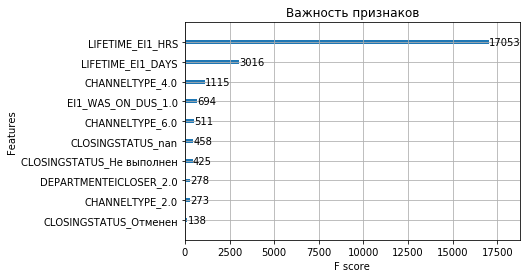

In [104]:
plt.figure(figsize=(20, 6))
plot_importance(grid_searched_xgb.best_estimator_, max_num_features=10, title='Важность признаков')
plt.show()

#### Замечания
1. Возможно надо сгруппировать значения в колонках DECLARED_FAULT, SOLUTION, DIAGNOSIS, чтобы уменьшить разнообразие в них. Судя по названию, в этих колонках содержится полезная информация.
2. В бустинге можно попробовать поменять функцию потерь на ту, которая будет больше штрафовать за неправильно предсказанные повторки или неправильно предсказанные одиночные обращения. Это зависит от того, что для нас хуже мануально разбирать случаи, когда повторка предсказана неверно и тратить на это время, или от того какой вред нам наносит пропущенная повторка.
3. Некоторые OBJECTID повторяются в файлах с повторкой и со всеми инфидентами. Возможно такие случаи надо выкалывать.